Charger & nettoyer le dataset
On nettoie :
- lignes "Order Date" répétées (headers dupliqués)
- types : quantity, price, dates
- suppression des valeurs invalides (quantité/prix <= 0)
- création de `zone = "City (ST)"` depuis `Purchase Address`

In [ ]:
import os, re, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RAW_URL = "https://raw.githubusercontent.com/ralesabelou-glitch/data-test/main/all_data.csv"
TARGETS = ["ThinkPad Laptop", "AAA Batteries (4-pack)"]

pd.set_option("display.max_columns", 50)

df = pd.read_csv(RAW_URL)

# 1) supprimer headers dupliqués
df = df[df["Order Date"].astype(str).str.lower() != "order date"].copy()

# 2) types
df["Quantity Ordered"] = pd.to_numeric(df["Quantity Ordered"], errors="coerce")
df["Price Each"] = pd.to_numeric(df["Price Each"], errors="coerce")
df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce")

# 3) enlever invalides
df = df.dropna(subset=["Order Date", "Purchase Address", "Product", "Quantity Ordered", "Price Each"])
df = df[(df["Quantity Ordered"] > 0) & (df["Price Each"] > 0)].copy()

# 4) zone "City (ST)"
def extract_city_state(addr: str):
    parts = [p.strip() for p in str(addr).split(",")]
    if len(parts) < 3:
        return np.nan, np.nan
    city = parts[-2]
    last = parts[-1].split()
    state = last[0] if len(last) >= 1 else np.nan
    return city, state

df[["city", "state"]] = df["Purchase Address"].apply(lambda x: pd.Series(extract_city_state(x)))
df = df.dropna(subset=["city", "state"]).copy()
df["zone"] = df["city"].astype(str).str.strip() + " (" + df["state"].astype(str).str.strip() + ")"

# 5) featurs
df["revenue"] = df["Quantity Ordered"] * df["Price Each"]
df["year_month"] = df["Order Date"].dt.to_period("M").dt.to_timestamp()

df.head()

/tmp/ipython-input-57278506.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce")


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,city,state,zone,revenue,year_month
0,176558,USB-C Charging Cable,2.0,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",Dallas,TX,Dallas (TX),23.90,2019-04-01
2,176559,Bose SoundSport Headphones,1.0,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",Boston,MA,Boston (MA),99.99,2019-04-01
3,176560,Google Phone,1.0,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",Los Angeles,CA,Los Angeles (CA),600.00,2019-04-01
4,176560,Wired Headphones,1.0,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",Los Angeles,CA,Los Angeles (CA),11.99,2019-04-01
5,176561,Wired Headphones,1.0,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",Los Angeles,CA,Los Angeles (CA),11.99,2019-04-01


## 2) Focus sur les 2 produits demandés

In [ ]:
df2 = df[df["Product"].isin(TARGETS)].copy()
df2["Product"].value_counts()

,count
Product,
AAA Batteries (4-pack),20641
ThinkPad Laptop,4128


In [ ]:
monthly = (
    df2.groupby(["Product", "zone", "year_month"], as_index=False)
       .agg(
           units=("Quantity Ordered", "sum"),
           revenue=("revenue", "sum"),
           orders=("Order ID", "nunique")
       )
       .sort_values(["Product","zone","year_month"])
)
monthly.head()

,Product,zone,year_month,units,revenue,orders
0,AAA Batteries (4-pack),Atlanta (GA),2019-01-01,131.0,391.69,87
1,AAA Batteries (4-pack),Atlanta (GA),2019-02-01,152.0,454.48,105
2,AAA Batteries (4-pack),Atlanta (GA),2019-03-01,183.0,547.17,133
3,AAA Batteries (4-pack),Atlanta (GA),2019-04-01,239.0,714.61,161
4,AAA Batteries (4-pack),Atlanta (GA),2019-05-01,210.0,627.90,132


Modèle baseline (scoring) : EWMA + growth_3m

- j' ai chosi EWMA(span=3) car ca donne plus de poids aux mois récents (proxy de la demande future)
- growth_3m : croissance relative entre le mois actuel et il y a 3 mois

Score final :
score = 0.7 * EWMA_last + 0.3 * (growth_3m clipped) * mean(EWMA_last)

In [ ]:
def score_zones(product_name: str, span=3):
    sub = monthly[monthly["Product"] == product_name].copy()
    piv = sub.pivot_table(index="year_month", columns="zone", values="units", aggfunc="sum").fillna(0).sort_index()

    ewma = piv.ewm(span=span, adjust=False).mean()
    ewma_last = ewma.iloc[-1]

    if len(piv) >= 4:
        growth_3m = (piv.iloc[-1] - piv.iloc[-4]) / (piv.iloc[-4] + 1e-9)
    else:
        growth_3m = pd.Series(0.0, index=piv.columns)

    score = 0.7 * ewma_last + 0.3 * (growth_3m.clip(-1, 5) * ewma_last.mean())

    out = pd.DataFrame({
        "zone": score.index,
        "score": score.values,
        "units_ewma_last": ewma_last.values,
        "growth_3m": growth_3m.values,
    }).sort_values("score", ascending=False).reset_index(drop=True)

    return out, piv

baseline = {}
pivots = {}
for p in TARGETS:
    baseline[p], pivots[p] = score_zones(p, span=3)

baseline["ThinkPad Laptop"].head(10)

,zone,score,units_ewma_last,growth_3m
0,San Francisco (CA),28.757524,50.874512,-1.000000
1,Los Angeles (CA),17.695955,34.939941,-0.986486
2,New York City (NY),16.140776,32.850586,-1.000000
3,Boston (MA),11.242005,25.656494,-0.980000
4,Atlanta (GA),7.562529,20.595947,-1.000000
5,Dallas (TX),6.911064,19.665283,-1.000000
6,Seattle (WA),5.619414,17.820068,-1.000000
7,Portland (OR),1.578008,12.046631,-1.000000
8,Austin (TX),1.015068,11.242432,-1.000000
9,Portland (ME),-4.897505,2.795898,-1.000000


Modèle ML : prédiction de la demande du mois suivant (forecast)

Approche :
- pivot zones × mois
- transformation supervised (long format)
- features : zone (one-hot), month/year, lags (t-1,t-2,t-3)
- modèle : HistGradientBoostingRegressor
- évaluation : MAE sur le dernier mois disponible
- prédiction : mois suivant pour chaque zone

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import HistGradientBoostingRegressor

def build_supervised(product_name: str, max_lag=3):
    sub = monthly[monthly["Product"] == product_name].copy()
    piv = sub.pivot_table(index="year_month", columns="zone", values="units", aggfunc="sum").fillna(0).sort_index()

    long = piv.reset_index().melt(id_vars="year_month", var_name="zone", value_name="units")
    long = long.sort_values(["zone", "year_month"])

    for k in range(1, max_lag + 1):
        long[f"lag_{k}"] = long.groupby("zone")["units"].shift(k)

    long["year"] = long["year_month"].dt.year
    long["month"] = long["year_month"].dt.month

    long = long.dropna(subset=[f"lag_{k}" for k in range(1, max_lag + 1)]).copy()
    return long

def forecast_next_month(product_name: str):
    data = build_supervised(product_name, max_lag=3)

    last_month = data["year_month"].max()
    train = data[data["year_month"] < last_month].copy()
    test  = data[data["year_month"] == last_month].copy()

    X_train = train[["zone", "year", "month", "lag_1", "lag_2", "lag_3"]]
    y_train = train["units"]
    X_test  = test[["zone", "year", "month", "lag_1", "lag_2", "lag_3"]]
    y_test  = test["units"]

    pre = ColumnTransformer([
        ("zone", OneHotEncoder(handle_unknown="ignore"), ["zone"]),
        ("num", "passthrough", ["year", "month", "lag_1", "lag_2", "lag_3"])
    ])

    model = HistGradientBoostingRegressor(random_state=42)
    pipe = Pipeline([("pre", pre), ("model", model)])
    pipe.fit(X_train, y_train)

    pred_test = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, pred_test)

    # next month
    next_month_dt = pd.Timestamp(last_month) + pd.offsets.MonthBegin(1)
    last = data[data["year_month"] == last_month].copy()
    last["year"] = next_month_dt.year
    last["month"] = next_month_dt.month

    X_next = last[["zone", "year", "month", "lag_1", "lag_2", "lag_3"]]
    last["pred_units_next_month"] = pipe.predict(X_next)

    out = last.groupby("zone", as_index=False)["pred_units_next_month"].mean()
    out = out.sort_values("pred_units_next_month", ascending=False)

    return out, mae

ml_forecasts = {}
ml_mae = {}
for p in TARGETS:
    ml_forecasts[p], ml_mae[p] = forecast_next_month(p)

ml_mae

{'ThinkPad Laptop': 49.101504732161395,
 'AAA Batteries (4-pack)': 399.1205383510836}

In [ ]:
for p in TARGETS:
    print("\n==== TOP 10 zones (prévision ML mois suivant) —", p, "====")
    print(ml_forecasts[p].head(10).to_string(index=False))


==== TOP 10 zones (prévision ML mois suivant) — ThinkPad Laptop ====
              zone  pred_units_next_month
  Los Angeles (CA)              73.734804
New York City (NY)              73.734804
San Francisco (CA)              73.734804
       Boston (MA)              63.078245
      Atlanta (GA)              49.830053
       Dallas (TX)              47.795297
     Portland (OR)              34.407357
      Seattle (WA)              32.243226
       Austin (TX)              31.850105
     Portland (ME)              12.606350

==== TOP 10 zones (prévision ML mois suivant) — AAA Batteries (4-pack) ====
              zone  pred_units_next_month
  Los Angeles (CA)             583.655244
New York City (NY)             583.655244
San Francisco (CA)             583.655244
       Boston (MA)             506.826553
       Dallas (TX)             421.838513
      Seattle (WA)             370.626454
      Atlanta (GA)             360.742927
     Portland (OR)             278.700320
       Austin

Heatmap : zones vs mois (unités)
On prend les Top N zones et on affiche une matrice (zones en lignes, mois en colonnes).

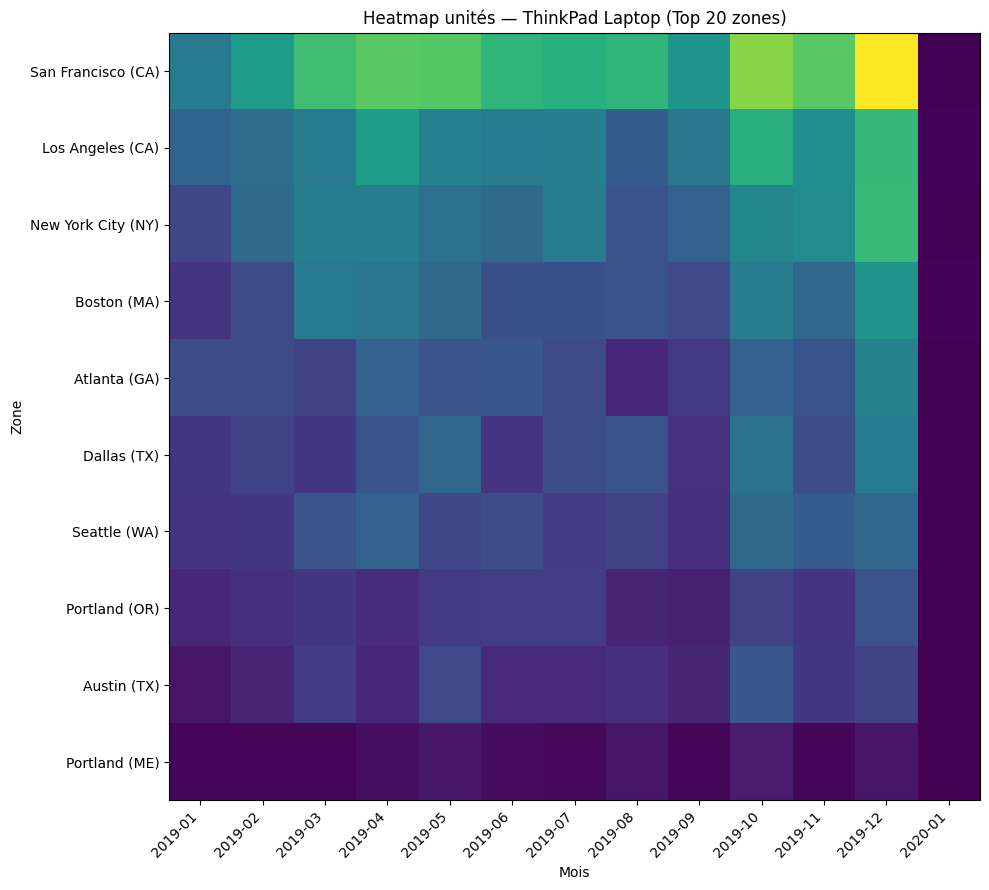

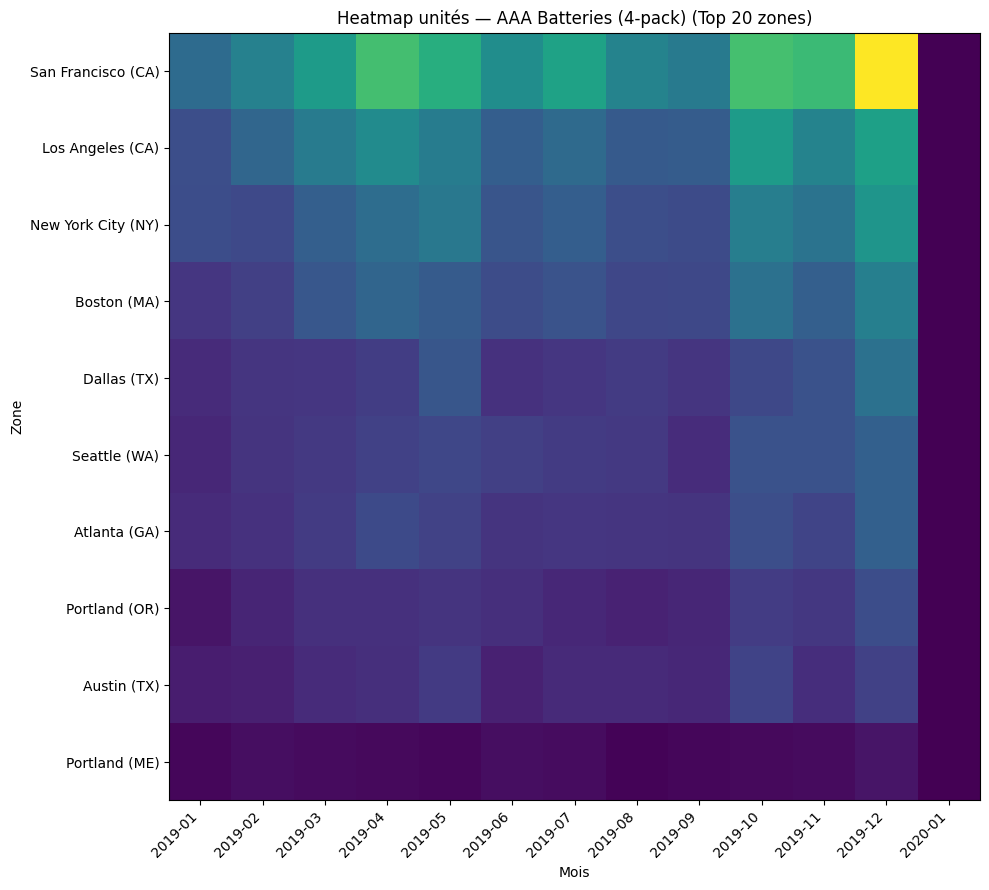

In [ ]:
def plot_zone_month_heatmap(product: str, top_n=20):
    piv = pivots[product]
    top_zones = baseline[product].head(top_n)["zone"].tolist()
    mat = piv[top_zones].T  # zones x months

    plt.figure(figsize=(10, 0.35*top_n + 2))
    plt.imshow(mat, aspect="auto")
    plt.title(f"Heatmap unités — {product} (Top {top_n} zones)")
    plt.xlabel("Mois")
    plt.ylabel("Zone")
    plt.xticks(range(len(mat.columns)), [c.strftime("%Y-%m") for c in mat.columns], rotation=45, ha="right")
    plt.yticks(range(len(mat.index)), mat.index)
    plt.tight_layout()
    plt.show()

plot_zone_month_heatmap("ThinkPad Laptop", top_n=20)
plot_zone_month_heatmap("AAA Batteries (4-pack)", top_n=20)

Assistant règles

In [ ]:
ZONE_PATTERN = re.compile(r"([A-Za-z .'\-]+)\s*\(\s*([A-Za-z]{2})\s*\)", re.IGNORECASE)

def extract_zones_from_text(text: str):
    matches = ZONE_PATTERN.findall(text or "")
    zones = []
    for city, stt in matches:
        zones.append(f"{city.strip()} ({stt.strip().upper()})")
    # unique preserve order
    out, seen = [], set()
    for z in zones:
        if z not in seen:
            out.append(z); seen.add(z)
    return out

def compare_zones(product: str, zone_a: str, zone_b: str, piv: pd.DataFrame, scores_df: pd.DataFrame) -> str:
    if zone_a not in piv.columns or zone_b not in piv.columns:
        missing = [z for z in [zone_a, zone_b] if z not in piv.columns]
        return f"Zones introuvables dans les données pour **{product}** : {', '.join(missing)}."

    a_series, b_series = piv[zone_a], piv[zone_b]
    a_last, b_last = float(a_series.iloc[-1]), float(b_series.iloc[-1])
    a_total, b_total = float(a_series.sum()), float(b_series.sum())

    a_score = float(scores_df.loc[scores_df["zone"] == zone_a, "score"].iloc[0])
    b_score = float(scores_df.loc[scores_df["zone"] == zone_b, "score"].iloc[0])

    winner = zone_a if a_score > b_score else zone_b
    return (
        f"Comparaison **{product}** :\n"
        f"- **{zone_a}** → dernier mois={a_last:.0f}, total={a_total:.0f}, score={a_score:.2f}\n"
        f"- **{zone_b}** → dernier mois={b_last:.0f}, total={b_total:.0f}, score={b_score:.2f}\n"
        f"➡️ Zone prioritaire : **{winner}**."
    )

Assistant LLM OpenAI

In [ ]:
# !pip install -U transformers accelerate sentencepiece

import json, re
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

MODEL_ID = "google/flan-t5-large"

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_ID)

ZONE_PATTERN = re.compile(r"([A-Za-z .'\-]+)\s*\(\s*([A-Za-z]{2})\s*\)", re.IGNORECASE)

def extract_zones_from_text(text: str):
    matches = ZONE_PATTERN.findall(text or "")
    zones = []
    for city, stt in matches:
        zones.append(f"{city.strip()} ({stt.strip().upper()})")
    out, seen = [], set()
    for z in zones:
        if z not in seen:
            out.append(z); seen.add(z)
    return out

def compare_zones(product, zone_a, zone_b, piv, scores_df):
    if zone_a not in piv.columns or zone_b not in piv.columns:
        missing = [z for z in [zone_a, zone_b] if z not in piv.columns]
        return f"Zones introuvables: {missing}"

    a_series, b_series = piv[zone_a], piv[zone_b]
    a_last, b_last = float(a_series.iloc[-1]), float(b_series.iloc[-1])
    a_total, b_total = float(a_series.sum()), float(b_series.sum())
    a_score = float(scores_df.loc[scores_df["zone"] == zone_a, "score"].iloc[0])
    b_score = float(scores_df.loc[scores_df["zone"] == zone_b, "score"].iloc[0])
    winner = zone_a if a_score > b_score else zone_b

    return (
        f"Comparaison {product}:\n"
        f"- {zone_a}: dernier mois={a_last:.0f}, total={a_total:.0f}, score={a_score:.2f}\n"
        f"- {zone_b}: dernier mois={b_last:.0f}, total={b_total:.0f}, score={b_score:.2f}\n"
        f"Zone prioritaire: {winner}"
    )

def flan_generate(prompt: str, max_new_tokens: int = 256) -> str:
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True)
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False
        )
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

def llm_answer(product: str, question: str) -> str:
    scores_df = baseline[product]
    piv = pivots[product]

    deterministic = None
    ql = (question or "").lower()
    if ("compare" in ql) or ("entre" in ql):
        zones = extract_zones_from_text(question)
        if len(zones) >= 2:
            deterministic = compare_zones(product, zones[0], zones[1], piv, scores_df)

    context = {
        "product": product,
        "top_zones": scores_df.head(15).to_dict(orient="records"),
        "computed_comparison": deterministic,
        "rules": [
            "Ne jamais inventer de zones ou de chiffres",
            "Si stock -> top 5 zones par score",
            "Si progression -> max growth_3m",
            "Si comparaison -> utiliser computed_comparison"
        ]
    }


    prompt = f"""
Tu es un assistant logistique d'aide à la décision.

CONTEXTE (résultats calculés):
{json.dumps(context, ensure_ascii=False)}

QUESTION:
{question}

Réponds en français, concis, actionnable. Ne jamais inventer.
""".strip()

    return flan_generate(prompt, max_new_tokens=220)

print(llm_answer("ThinkPad Laptop", "Où devrais-je augmenter les stocks de ThinkPad Laptop ?"))
#print(llm_answer("ThinkPad Laptop", "Quelle ville montre la plus forte progression de la demande ?"))
#print(llm_answer("ThinkPad Laptop", "Compare la demande entre Dallas (TX) et Houston (TX)"))

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/558 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

["zone": "San Francisco (CA)", "score": 28.757524414133165, "units_ewma_last": 50.87451171875, "growth_3m": -0.9999999999896907, "zone": "Los Angeles (CA)", "score": 17.695955381742557, "units_ewma_last": 34.93994140625, "growth_3m": -0.9999999999814816, "zone": "New York City (NY)", "score": 16.140776367314437, "units_ewma_last": 32.8505859375, "growth_3m": -0.9999999999814816, "zone": "Boston (MA)", "score": 11.24
